In [1]:
import matplotlib.pyplot as plt
import torch

from ambitsinn import ACF, GaussianKDE, GaussianTrawlProcess

In [2]:
process = GaussianTrawlProcess(integrated_trawl_function=lambda x: torch.exp(-x))
times = torch.linspace(0, 50, 1001)

In [3]:
data = process.sample(times, batch_size=500)

## Plot ACF and PDF

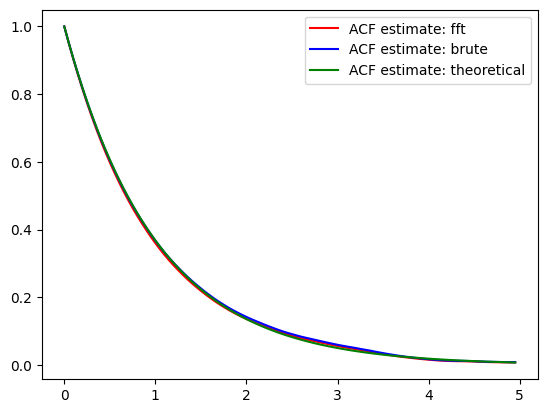

In [4]:
LAGS = 100
plt.plot(times[:LAGS].numpy(), ACF(lags=LAGS, method="fft")(data).numpy(), color="r", label="ACF estimate: fft")
plt.plot(times[:LAGS].numpy(), ACF(lags=LAGS, method="brute")(data).numpy(), color="b", label="ACF estimate: brute")
plt.plot(times[:LAGS].numpy(), process.acf(times[:LAGS]).numpy(), color="g", label="ACF estimate: theoretical")
plt.legend()

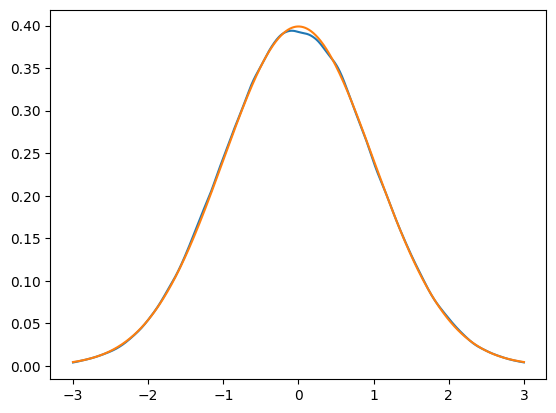

In [5]:
plt.plot(torch.linspace(-3, 3, 1000).numpy(), GaussianKDE(lower=-3, upper=3, n=1000)(data).numpy())
plt.plot(torch.linspace(-3, 3, 1000).numpy(), process.pdf(torch.linspace(-3, 3, 1000)).numpy())

## Create basic loss

Analytical loss:

In [6]:
from ambitsinn import ACFLoss, DensityLoss

In [7]:
fdd = process.at_times(times)
loss_kde = DensityLoss.analytical(fdd, lower=-2.0, upper=2.0, n=400)
loss_acf = ACFLoss.analytical(fdd, lags=100)
loss = 2 * loss_acf + loss_kde

data = fdd.sample(batch_size=500)
print("ACF loss:", loss_acf(data), "KDE loss:", loss_kde(data), "Total:", loss(data))

ACF loss: tensor(0.0941) KDE loss: tensor(9.9331e-06) Total: tensor(0.1883)


Loss built from data:

In [8]:
target_data = fdd.sample(batch_size=1000)

loss_kde_emp = DensityLoss.empirical(target_data, lower=-2.0, upper=2.0, n=40)
loss_acf_emp = ACFLoss.empirical(target_data, lags=100, method="brute")
loss_emp = loss_acf_emp + loss_kde_emp

data = fdd.sample(batch_size=250)
print("ACF loss:", loss_acf_emp(data), "KDE loss:", loss_kde_emp(data), "Total:", loss_emp(data))

ACF loss: tensor(0.0951) KDE loss: tensor(1.6312e-05) Total: tensor(0.0951)


## Losses based on charfuncs

In [9]:
from ambitsinn import CFRollingWindowLoss

times = torch.linspace(0, 1, 11)
fdd = process.at_times(times)
data = fdd.sample(batch_size=2500)

In [10]:
cfloss = CFRollingWindowLoss.analytical(process=process, times=times)

In [11]:
cfloss(data)

tensor(0.2402)

In [12]:
target_data = fdd.sample(batch_size=5000)
cfloss_emp = CFRollingWindowLoss.empirical(target_data)

In [13]:
cfloss_emp(data)

tensor(0.3585)